<a href="https://colab.research.google.com/github/robert-shepherd/fpl/blob/main/Project_4_scoring_new_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scoring new data


---

The purpose of this script is to score new data using the saved model

Data sources:
* Model:  fpl_xgb_model.dat
* List of features used to train the model: fpl_xgb_model_variables.csv
* FPL API

Output:
* Player data: player_data.parquet
* History data: history_data.parquet
* Fixture (prediction) data: fixture_data.parquet
* Team data: team_data.parquet

In [ ]:
# Loading libraries
import pandas as pd
import pickle
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import auth
from datetime import datetime

# Model libraries
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
# Authorise login to access files from GCS
# auth.authenticate_user()
# Note: above required to write to GCS

## Reading in the model

In [ ]:
# Setting variables
project_id = 'fpl-scoring'
bucket_name = 'fpl-scoring'
!gcloud config set project {project_id}

Updated property [core/project].


In [ ]:
# Copying files locally from Google Cloud Storage
!gsutil cp gs://{bucket_name}/fpl_xgb_model_variables.csv .
!gsutil cp gs://{bucket_name}/fpl_xgb_model.dat .

Copying gs://fpl-scoring/fpl_xgb_model_variables.csv...
/ [1 files][  626.0 B/  626.0 B]                                                
Operation completed over 1 objects/626.0 B.                                      
Copying gs://fpl-scoring/fpl_xgb_model.dat...
/ [1 files][ 67.2 KiB/ 67.2 KiB]                                                
Operation completed over 1 objects/67.2 KiB.                                     


In [ ]:
# Reading in model
fpl_model = pickle.load(open('fpl_xgb_model.dat', 'rb'))
print(fpl_model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.65, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=6, missing=nan, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.85, verbosity=1)


In [ ]:
# Read in a list of variables used to train the model
fpl_variables_df = pd.read_csv('fpl_xgb_model_variables.csv',header=None)

fpl_variables = fpl_variables_df[0].tolist()

print(fpl_variables)

['opponent_strength', 'points_lag_1', 'points_lag_2', 'points_lag_3', 'points_lag_4', 'points_lag_5', 'minutes_lag', 'minutes_rolling', 'goals_scored_lag', 'goals_scored_rolling', 'assists_lag', 'assists_rolling', 'clean_sheets_lag', 'clean_sheets_rolling', 'goals_conceded_lag', 'goals_conceded_rolling', 'saves_lag', 'saves_rolling', 'cards_lag', 'cards_rolling', 'bonus_lag', 'bonus_rolling', 'bps_lag', 'bps_rolling', 'influence_lag', 'influence_rolling', 'creativity_lag', 'creativity_rolling', 'threat_lag', 'threat_rolling', 'selected_lag', 'selected_rolling', 'transfers_in_ratio_lag', 'transfers_in_ratio_rolling', 'transfers_out_ratio_lag', 'transfers_out_ratio_rolling', 'was_home_True', 'position_FWD', 'position_GKP', 'position_MID']


## Reading in and preparing data

In [ ]:
# Import data from API
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
json = r.json()
json.keys()

dict_keys(['events', 'game_settings', 'phases', 'teams', 'total_players', 'elements', 'element_stats', 'element_types'])

In [ ]:
# Create a dataframe of live elements
elements = pd.DataFrame(json['elements'])
elements.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text
0,0.0,0.0,37605,0,0,-3,3,0,3,0.0,0.0,0,Mesut,0.0,1,False,Not included in Arsenal's 25-man Premier Leagu...,2020-10-20T22:30:18.118477Z,67,37605.jpg,0.0,Özil,0.5,False,None,u,1,3,0,3441,0,54665,50,0.0,0.0,Özil,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,686,278,686,278,686,278,686,278,NaN,,NaN,,NaN,
1,0.0,0.0,39476,0,0,-2,2,0,2,0.0,0.0,0,Sokratis,0.0,2,False,Left the club by mutual consent on 20/1,2020-10-21T10:30:18.546407Z,48,39476.jpg,0.0,Papastathopoulos,0.1,False,None,u,1,3,0,10266,0,19109,3,0.0,0.0,Sokratis,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,649,232,641,233,633,230,652,232,NaN,,NaN,,NaN,
2,100.0,100.0,41270,0,0,-1,1,0,2,1.7,1.7,1,David,1.7,3,False,,2021-02-02T20:30:22.388696Z,54,41270.jpg,2.1,Luiz Moreira Marinho,1.0,False,None,a,1,3,40,76129,828,114187,2842,0.3,7.4,David Luiz,1344,1,0,3,20,0,0,0,1,1,0,0,223,244.6,45.2,123.0,41.0,217,87,324,105,219,61,272,90,NaN,,4.0,,NaN,
3,100.0,100.0,54694,0,0,-5,5,2,3,3.3,3.3,2,Pierre-Emerick,3.3,4,False,,2021-01-23T16:00:22.555453Z,115,54694.jpg,4.4,Aubameyang,10.9,False,None,a,1,3,106,1107919,4959,3437343,81604,0.3,9.2,Aubameyang,1931,9,1,7,23,1,0,0,2,0,0,10,296,414.0,266.2,729.0,140.7,108,37,103,70,27,15,41,27,NaN,,NaN,,1.0,
4,100.0,100.0,58822,0,0,-4,4,0,2,0.7,0.7,0,Cédric,0.7,5,False,,2020-09-23T09:00:14.881983Z,46,58822.jpg,3.1,Soares,0.3,False,None,a,1,3,28,28858,185,51581,660,0.2,6.1,Cédric,699,0,1,2,8,0,0,0,1,0,0,3,121,103.4,112.3,49.0,26.5,332,130,223,54,323,113,332,117,NaN,,5.0,,NaN,


In [ ]:
# Create a dataframe of teams
teams = pd.DataFrame(json['teams'])
teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,4,None,False,0,1190,1210,1170,1210,1190,1200,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,3,None,False,0,1150,1150,1150,1150,1180,1210,2
2,36,0,None,3,0,Brighton,0,0,0,BHA,3,None,False,0,1120,1100,1150,1180,1090,1100,131
3,90,0,None,4,0,Burnley,0,0,0,BUR,3,None,False,0,1070,1080,1120,1190,1010,1030,43
4,8,0,None,5,0,Chelsea,0,0,0,CHE,4,None,False,0,1250,1300,1240,1280,1270,1310,4


In [ ]:
# Create a lookup from element to element_type
element_type_ref = elements[['id','element_type']]
element_type_ref.columns = ['element','element_type']
element_type_ref.head()

,element,element_type
0,1,3
1,2,2
2,3,2
3,4,3
4,5,2


In [ ]:
# Create a dataframe of element types to get position
element_types = pd.DataFrame(json['element_types'])
element_types.head()

,id,plural_name,plural_name_short,singular_name,singular_name_short,squad_select,squad_min_play,squad_max_play,ui_shirt_specific,sub_positions_locked,element_count
0,1,Goalkeepers,GKP,Goalkeeper,GKP,2,1,1,True,[12],80
1,2,Defenders,DEF,Defender,DEF,5,3,5,False,[],239
2,3,Midfielders,MID,Midfielder,MID,5,2,5,False,[],278
3,4,Forwards,FWD,Forward,FWD,3,1,3,False,[],89


In [ ]:
# Extracting position from the element_types data
position = element_types[['id','singular_name_short']]
position.columns = ['element_type','position']
position.head()

,element_type,position
0,1,GKP
1,2,DEF
2,3,MID
3,4,FWD


In [ ]:
# Create a dataframe of teams to get opponent strength
teams = pd.DataFrame(json['teams'])
teams.head()

,code,draw,form,id,loss,name,played,points,position,short_name,strength,team_division,unavailable,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,0,ARS,4,None,False,0,1190,1210,1170,1210,1190,1200,1
1,7,0,None,2,0,Aston Villa,0,0,0,AVL,3,None,False,0,1150,1150,1150,1150,1180,1210,2
2,36,0,None,3,0,Brighton,0,0,0,BHA,3,None,False,0,1120,1100,1150,1180,1090,1100,131
3,90,0,None,4,0,Burnley,0,0,0,BUR,3,None,False,0,1070,1080,1120,1190,1010,1030,43
4,8,0,None,5,0,Chelsea,0,0,0,CHE,4,None,False,0,1250,1300,1240,1280,1270,1310,4


In [ ]:
# Extracting opponent_strength from the teams data
opponents = teams[['id','strength']]
opponents.columns = ['opponent_team','opponent_strength']
opponents.head()

,opponent_team,opponent_strength
0,1,4
1,2,3
2,3,3
3,4,3
4,5,4


In [ ]:
# Loop through history and create a file
for x in elements.index :
    element_id = elements.id[x]
    url = f'https://fantasy.premierleague.com/api/element-summary/{element_id}/'
    r = requests.get(url)
    json = r.json()
    json_history = pd.DataFrame(json['history'])
    
    if x == 0 :
        history = json_history
    else : 
        history = history.append(json_history)

history.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840


In [ ]:
# Merging element type reference
history_type = pd.merge(history,element_type_ref,on='element')
history_type.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823,3
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126,3
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971,3
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840,3


In [ ]:
# Merging position type reference
history_pos = pd.merge(history_type,position,on='element_type')
history_pos.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID
1,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823,3,MID
2,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126,3,MID
3,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971,3,MID
4,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840,3,MID


In [ ]:
# Merging opposition difficulty
df = pd.merge(history_pos,opponents,on='opponent_team')
df.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID,3
1,4,2,8,7,False,2020-09-12T11:30:00Z,0,3,1,90,1,0,1,0,0,0,0,1,0,0,0,19,36.6,15.3,54.0,10.6,120,0,2823465,0,0,3,MID,3
2,9,2,8,3,False,2020-09-12T11:30:00Z,0,3,1,77,0,0,1,0,0,0,0,0,0,0,0,11,6.8,17.2,21.0,4.5,55,0,42909,0,0,3,MID,3
3,18,2,8,1,False,2020-09-12T11:30:00Z,0,3,1,15,0,0,0,0,0,0,0,0,0,0,0,3,2.0,15.3,6.0,2.3,80,0,132947,0,0,3,MID,3
4,19,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,50,0,15039,0,0,3,MID,3


In [ ]:
# Casting latest season influence, creativity, threat and ict_index to float
df['influence'] = df['influence'].astype(float)
df['creativity'] = df['creativity'].astype(float)
df['threat'] = df['threat'].astype(float)
df['ict_index'] = df['ict_index'].astype(float)
df.dtypes

element                int64
fixture                int64
opponent_team          int64
total_points           int64
was_home                bool
kickoff_time          object
team_h_score           int64
team_a_score           int64
round                  int64
minutes                int64
goals_scored           int64
assists                int64
clean_sheets           int64
goals_conceded         int64
own_goals              int64
penalties_saved        int64
penalties_missed       int64
yellow_cards           int64
red_cards              int64
saves                  int64
bonus                  int64
bps                    int64
influence            float64
creativity           float64
threat               float64
ict_index            float64
value                  int64
transfers_balance      int64
selected               int64
transfers_in           int64
transfers_out          int64
element_type           int64
position              object
opponent_strength      int64
dtype: object

## Creating calculated features

In [ ]:
# Updating data to remove variables and create a new cards variable
def num_cards(df):
    if df['red_cards'] == 1:
        return 2
    elif df['yellow_cards'] == 1:
        return 1
    else:
        return 0

df['cards'] = df.apply(num_cards, axis = 1)

df.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,cards
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID,3,0
1,4,2,8,7,False,2020-09-12T11:30:00Z,0,3,1,90,1,0,1,0,0,0,0,1,0,0,0,19,36.6,15.3,54.0,10.6,120,0,2823465,0,0,3,MID,3,1
2,9,2,8,3,False,2020-09-12T11:30:00Z,0,3,1,77,0,0,1,0,0,0,0,0,0,0,0,11,6.8,17.2,21.0,4.5,55,0,42909,0,0,3,MID,3,0
3,18,2,8,1,False,2020-09-12T11:30:00Z,0,3,1,15,0,0,0,0,0,0,0,0,0,0,0,3,2.0,15.3,6.0,2.3,80,0,132947,0,0,3,MID,3,0
4,19,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,50,0,15039,0,0,3,MID,3,0


In [ ]:
# Transforming transfer variables
df['transfers_in_ratio'] = df['transfers_in'] / df['selected']
df['transfers_out_ratio'] = df['transfers_out'] / df['selected']

In [ ]:
# Sorting data before creating lag features
df_sorted = df.sort_values(by=['element','round','fixture'],ascending=True).copy()
df_sorted.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,cards,transfers_in_ratio,transfers_out_ratio
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID,3,0,0.000000,0.000000
930,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823,3,MID,4,0,0.014561,0.260818
1835,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126,3,MID,4,0,0.011289,0.202800
2736,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971,3,MID,2,0,0.011471,0.105863
3639,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840,3,MID,5,0,0.011473,0.090149


In [ ]:
# Appending points lag features
selected_columns = ['total_points']

for i in range(30):
  num = i
  lag_var = 'points_lag_' + str(num)
  
  df_sorted[lag_var] = df_sorted.groupby(['element'])['total_points'].shift(num)

  selected_columns.append(lag_var)

df_sorted.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,cards,transfers_in_ratio,transfers_out_ratio,points_lag_0,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,points_lag_6,points_lag_7,points_lag_8,points_lag_9,points_lag_10,points_lag_11,points_lag_12,points_lag_13,points_lag_14,points_lag_15,points_lag_16,points_lag_17,points_lag_18,points_lag_19,points_lag_20,points_lag_21,points_lag_22,points_lag_23,points_lag_24,points_lag_25,points_lag_26,points_lag_27,points_lag_28,points_lag_29
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID,3,0,0.000000,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
930,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823,3,MID,4,0,0.014561,0.260818,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1835,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126,3,MID,4,0,0.011289,0.202800,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2736,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971,3,MID,2,0,0.011471,0.105863,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3639,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840,3,MID,5,0,0.011473,0.090149,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Appending lag features for other variables

df_features = df_sorted.copy()

variables_to_lag = ['minutes','goals_scored','assists','clean_sheets'
,'goals_conceded','saves','cards','bonus','bps','influence','creativity'
,'threat','selected','transfers_in_ratio','transfers_out_ratio']

for i in variables_to_lag:
  lag_var = i + str("_lag")
  rolling_var = i + str("_rolling")
  # Note: lag variable changed to "0" so that latest information is lag 1
  df_features[lag_var] = df_features.groupby(['element'])[i].shift(0)
  df_features[rolling_var] = df_features.groupby(['element'])[lag_var].rolling(5).mean().values

df_features.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,cards,transfers_in_ratio,transfers_out_ratio,points_lag_0,points_lag_1,points_lag_2,...,points_lag_20,points_lag_21,points_lag_22,points_lag_23,points_lag_24,points_lag_25,points_lag_26,points_lag_27,points_lag_28,points_lag_29,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling
0,1,2,8,0,False,2020-09-12T11:30:00Z,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,70,0,76656,0,0,3,MID,3,0,0.000000,0.000000,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,76656,NaN,0.000000,NaN,0.000000,NaN
930,1,9,19,0,True,2020-09-19T19:00:00Z,2,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-16828,68335,995,17823,3,MID,4,0,0.014561,0.260818,0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,68335,NaN,0.014561,NaN,0.260818,NaN
1835,1,23,11,0,False,2020-09-28T19:00:00Z,3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,69,-11451,59793,675,12126,3,MID,4,0,0.011289,0.202800,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,59793,NaN,0.011289,NaN,0.202800,NaN
2736,1,29,15,0,True,2020-10-04T13:00:00Z,2,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-5324,56403,647,5971,3,MID,2,0,0.011471,0.105863,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,56403,NaN,0.011471,NaN,0.105863,NaN
3639,1,44,12,0,False,2020-10-17T16:30:00Z,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,68,-4224,53689,616,4840,3,MID,5,0,0.011473,0.090149,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53689,62975.2,0.011473,0.009759,0.090149,0.131926


In [ ]:
# Identifying the latest fixture for each element
latest_fixture = df.groupby(['element'], sort=False)['fixture'].max().to_frame()
latest_fixture

,fixture
element,
1,288
4,288
9,288
18,288
19,288
...,...
683,276
680,287
679,287


In [ ]:
# Selecting only data for the latest features for each element
latest_fixture_data = pd.merge(
    df_features,
    latest_fixture,
    how="inner",
    on=['element','fixture'],
)

latest_fixture_data.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,cards,transfers_in_ratio,transfers_out_ratio,points_lag_0,points_lag_1,points_lag_2,...,points_lag_20,points_lag_21,points_lag_22,points_lag_23,points_lag_24,points_lag_25,points_lag_26,points_lag_27,points_lag_28,points_lag_29,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling
0,1,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,67,-48,41707,0,48,3,MID,4,0,0.000000,0.001151,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,41707,41846.4,0.000000,5.421011e-19,0.001151,0.002177
1,2,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,48,-11,4650,0,11,2,DEF,4,0,0.000000,0.002366,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,4650,4674.6,0.000000,0.000000e+00,0.002366,0.003205
2,3,288,19,1,False,2021-03-21T15:00:00Z,3,3,29,90,0,0,0,3,0,0,0,0,0,0,0,17,20.0,1.0,10.0,3.1,54,10883,92390,12847,1964,2,DEF,4,0,0.139052,0.021258,1,2.0,2.0,...,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,NaN,90,73.6,0,0.2,0,0.0,0,0.0,3,1.2,0,0.0,0,0.0,0,0.0,17,14.4,20.0,19.32,1.0,0.68,10.0,6.6,92390,70310.4,0.139052,6.098544e-02,0.021258,0.025019
3,4,288,19,2,False,2021-03-21T15:00:00Z,3,3,29,80,0,0,0,3,0,0,0,0,0,0,0,8,5.6,5.3,6.0,1.7,115,305129,1218307,320820,15691,3,MID,4,0,0.263333,0.012879,2,0.0,8.0,...,3.0,2.0,8.0,2.0,2.0,2.0,2.0,5.0,7.0,NaN,80,53.4,0,0.2,0,0.0,0,0.0,3,1.0,0,0.0,0,0.0,0,0.2,8,6.4,5.6,7.32,5.3,2.26,6.0,16.6,1218307,712671.4,0.263333,1.180721e-01,0.012879,0.022350
4,5,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,46,1192,24340,1914,722,2,DEF,4,0,0.078636,0.029663,0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,36.0,0,0.0,0,0.0,0,0.0,0,0.4,0,0.0,0,0.0,0,0.0,0,4.2,0.0,4.28,0.0,2.86,0.0,1.2,24340,23575.4,0.078636,4.798652e-02,0.029663,0.070605


## Appending future fixtures

In [ ]:
# Loop through fixtures and create a file
for x in elements.index :
    element_id = elements.id[x]
    url = f'https://fantasy.premierleague.com/api/element-summary/{element_id}/'
    r = requests.get(url)
    json = r.json()
    json_fixtures = pd.DataFrame(json['fixtures'])
    json_fixtures['element'] = element_id
    
    if x == 0 :
        fixtures = json_fixtures
    else : 
        fixtures = fixtures.append(json_fixtures)

fixtures.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1
1,305,2128592,15,None,1,None,31.0,False,0,False,2021-04-11T18:00:00Z,Gameweek 31,False,2,1
2,309,2128596,1,None,8,None,32.0,False,0,False,2021-04-18T12:30:00Z,Gameweek 32,True,2,1
3,319,2128606,1,None,7,None,33.0,False,0,False,2021-04-23T19:00:00Z,Gameweek 33,True,4,1
4,335,2128622,14,None,1,None,34.0,False,0,False,2021-05-01T14:00:00Z,Gameweek 34,False,3,1


In [ ]:
# Deriving opponent team
fixtures['opponent_team'] = np.where(
     fixtures['is_home']==True, 
     fixtures['team_a'], 
     fixtures['team_h']
     )

fixtures.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,opponent_team
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1,11
1,305,2128592,15,None,1,None,31.0,False,0,False,2021-04-11T18:00:00Z,Gameweek 31,False,2,1,15
2,309,2128596,1,None,8,None,32.0,False,0,False,2021-04-18T12:30:00Z,Gameweek 32,True,2,1,8
3,319,2128606,1,None,7,None,33.0,False,0,False,2021-04-23T19:00:00Z,Gameweek 33,True,4,1,7
4,335,2128622,14,None,1,None,34.0,False,0,False,2021-05-01T14:00:00Z,Gameweek 34,False,3,1,14


In [ ]:
# Merging opposition difficulty
fixtures_opp = pd.merge(fixtures,opponents,on='opponent_team')
fixtures_opp.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,opponent_team,opponent_strength
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1,11,4
1,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,2,11,4
2,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,3,11,4
3,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,4,11,4
4,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,5,11,4


In [ ]:
# Joining to latest data
fixture_features = pd.merge(
    fixtures_opp,
    latest_fixture_data,
    how='left',
    on='element',
    suffixes=[None,'_y']
    )

fixture_features.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,opponent_team,opponent_strength,fixture,opponent_team_y,total_points,was_home,kickoff_time_y,team_h_score_y,team_a_score_y,round,minutes_y,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,...,points_lag_20,points_lag_21,points_lag_22,points_lag_23,points_lag_24,points_lag_25,points_lag_26,points_lag_27,points_lag_28,points_lag_29,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1,11,4,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,41707,41846.4,0.000000,5.421011e-19,0.001151,0.002177
1,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,2,11,4,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,4650,4674.6,0.000000,0.000000e+00,0.002366,0.003205
2,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,3,11,4,288,19,1,False,2021-03-21T15:00:00Z,3,3,29,90,0,0,0,3,0,0,0,0,0,0,0,17,20.0,1.0,...,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,NaN,90,73.6,0,0.2,0,0.0,0,0.0,3,1.2,0,0.0,0,0.0,0,0.0,17,14.4,20.0,19.32,1.0,0.68,10.0,6.6,92390,70310.4,0.139052,6.098544e-02,0.021258,0.025019
3,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,4,11,4,288,19,2,False,2021-03-21T15:00:00Z,3,3,29,80,0,0,0,3,0,0,0,0,0,0,0,8,5.6,5.3,...,3.0,2.0,8.0,2.0,2.0,2.0,2.0,5.0,7.0,NaN,80,53.4,0,0.2,0,0.0,0,0.0,3,1.0,0,0.0,0,0.0,0,0.2,8,6.4,5.6,7.32,5.3,2.26,6.0,16.6,1218307,712671.4,0.263333,1.180721e-01,0.012879,0.022350
4,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,5,11,4,288,19,0,False,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,36.0,0,0.0,0,0.0,0,0.0,0,0.4,0,0.0,0,0.0,0,0.0,0,4.2,0.0,4.28,0.0,2.86,0.0,1.2,24340,23575.4,0.078636,4.798652e-02,0.029663,0.070605


## Scoring future fixtures

In [ ]:
# One hot encoding categorical variables
fixture_features_encoded = pd.get_dummies(data=fixture_features, columns=['was_home','position'],
                            drop_first=False)

fixture_features_encoded.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,opponent_team,opponent_strength,fixture,opponent_team_y,total_points,kickoff_time_y,team_h_score_y,team_a_score_y,round,minutes_y,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,...,points_lag_26,points_lag_27,points_lag_28,points_lag_29,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling,was_home_False,was_home_True,position_DEF,position_FWD,position_GKP,position_MID
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1,11,4,288,19,0,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,41707,41846.4,0.000000,5.421011e-19,0.001151,0.002177,1,0,0,0,0,1
1,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,2,11,4,288,19,0,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,4650,4674.6,0.000000,0.000000e+00,0.002366,0.003205,1,0,1,0,0,0
2,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,3,11,4,288,19,1,2021-03-21T15:00:00Z,3,3,29,90,0,0,0,3,0,0,0,0,0,0,0,17,20.0,1.0,10.0,...,1.0,1.0,0.0,NaN,90,73.6,0,0.2,0,0.0,0,0.0,3,1.2,0,0.0,0,0.0,0,0.0,17,14.4,20.0,19.32,1.0,0.68,10.0,6.6,92390,70310.4,0.139052,6.098544e-02,0.021258,0.025019,1,0,1,0,0,0
3,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,4,11,4,288,19,2,2021-03-21T15:00:00Z,3,3,29,80,0,0,0,3,0,0,0,0,0,0,0,8,5.6,5.3,6.0,...,2.0,5.0,7.0,NaN,80,53.4,0,0.2,0,0.0,0,0.0,3,1.0,0,0.0,0,0.0,0,0.2,8,6.4,5.6,7.32,5.3,2.26,6.0,16.6,1218307,712671.4,0.263333,1.180721e-01,0.012879,0.022350,1,0,0,0,0,1
4,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,5,11,4,288,19,0,2021-03-21T15:00:00Z,3,3,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0,36.0,0,0.0,0,0.0,0,0.0,0,0.4,0,0.0,0,0.0,0,0.0,0,4.2,0.0,4.28,0.0,2.86,0.0,1.2,24340,23575.4,0.078636,4.798652e-02,0.029663,0.070605,1,0,1,0,0,0


In [ ]:
# Selecting fields used for scoring
fixtures_to_score = fixture_features_encoded[fpl_variables].copy()

fixtures_to_score.head()

,opponent_strength,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling,was_home_True,position_FWD,position_GKP,position_MID
0,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,41707,41846.4,0.000000,5.421011e-19,0.001151,0.002177,0,0,0,1
1,4,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,4650,4674.6,0.000000,0.000000e+00,0.002366,0.003205,0,0,0,0
2,4,2.0,2.0,8.0,1.0,1.0,90,73.6,0,0.2,0,0.0,0,0.0,3,1.2,0,0.0,0,0.0,0,0.0,17,14.4,20.0,19.32,1.0,0.68,10.0,6.6,92390,70310.4,0.139052,6.098544e-02,0.021258,0.025019,0,0,0,0
3,4,0.0,8.0,1.0,2.0,20.0,80,53.4,0,0.2,0,0.0,0,0.0,3,1.0,0,0.0,0,0.0,0,0.2,8,6.4,5.6,7.32,5.3,2.26,6.0,16.6,1218307,712671.4,0.263333,1.180721e-01,0.012879,0.022350,0,0,0,1
4,4,2.0,0.0,2.0,0.0,1.0,0,36.0,0,0.0,0,0.0,0,0.0,0,0.4,0,0.0,0,0.0,0,0.0,0,4.2,0.0,4.28,0.0,2.86,0.0,1.2,24340,23575.4,0.078636,4.798652e-02,0.029663,0.070605,0,0,0,0


In [ ]:
# Using the model to score data
fpl_model_predictions = fpl_model.predict(fixtures_to_score)
fpl_model_predictions.shape

(6175,)

In [ ]:
# Joining predictions back on to fixtures table
fixtures_scored = fixtures_opp.copy()

fixtures_scored['predicted_score'] = fpl_model_predictions

fixtures_scored.head()

,id,code,team_h,team_h_score,team_a,team_a_score,event,finished,minutes,provisional_start_time,kickoff_time,event_name,is_home,difficulty,element,opponent_team,opponent_strength,predicted_score
0,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,1,11,4,0.057246
1,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,2,11,4,-0.006872
2,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,3,11,4,2.350660
3,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,4,11,4,2.185947
4,289,2128576,1,None,11,None,30.0,False,0,False,2021-04-03T19:00:00Z,Gameweek 30,True,4,5,11,4,0.845013


In [ ]:
# Removing fixtures where event is missing and adding a row number
fixtures_scored_clean = fixtures_scored[fixtures_scored['event'].isna()==False]
fixtures_scored_clean['fixture_rank'] = fixtures_scored_clean.event.rank(method='dense')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Checking score distribution

In [ ]:
# Checking min/max prediction
min_pred = min(fpl_model_predictions)
max_pred = max(fpl_model_predictions)
print("Min prediction: {}".format(min_pred))
print("Max prediction: {}".format(max_pred))

Min prediction: -0.04280120134353638
Max prediction: 7.796689510345459


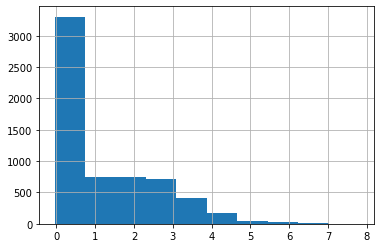

In [ ]:
# Checking predictions distribution
fixtures_scored['predicted_score'].hist()
plt.show()

## Outputting data files for dashboards

In [ ]:
# Appending last updated to tables
elements['last_updated'] = datetime.now()
teams['last_updated'] = datetime.now()
df['last_updated'] = datetime.now()
fixtures_scored_clean['last_updated'] = datetime.now()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Outputting elements data
elements.to_parquet('player_data.parquet', index=False, compression='snappy')

In [ ]:
# Outputting teams data
teams.to_parquet('team_data.parquet', index=False, compression='snappy')

In [ ]:
# Outputting historical data (prior to lag feature creation)
df.to_parquet('history_data.parquet', index=False, compression='snappy')

In [ ]:
# Outputting predictions for future fixtures
fixtures_scored_clean.to_parquet('fixture_data.parquet', index=False, compression='snappy')

In [ ]:
# Copying over files to GCS
# !gsutil cp player_data.parquet gs://{bucket_name}
# !gsutil cp history_data.parquet gs://{bucket_name}
# !gsutil cp fixture_data.parquet gs://{bucket_name}
# !gsutil cp team_data.parquet gs://{bucket_name}
# Note: above overwrites files in GCS and requires an authorised account logged in

Copying file://player_data.parquet [Content-Type=application/octet-stream]...
/ [1 files][151.5 KiB/151.5 KiB]                                                
Operation completed over 1 objects/151.5 KiB.                                    
Copying file://history_data.parquet [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/815.7 KiB.                                    
Copying file://fixture_data.parquet [Content-Type=application/octet-stream]...
/ [1 files][ 38.0 KiB/ 38.0 KiB]                                                
Operation completed over 1 objects/38.0 KiB.                                     
Copying file://team_data.parquet [Content-Type=application/octet-stream]...
/ [1 files][ 15.7 KiB/ 15.7 KiB]                                                
Operation completed over 1 objects/15.7 KiB.                                     
